In [2]:
import torch
import torch.nn as nn
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [421]:
file = fits.getdata('data/gamma1_measured_2.fits')


I have produced data with input $\gamma_1$ from $0.01$ to $0.05$, with some random flexion ($F_1,F_2,G_1,G_2$) at first. 

If we want to apply the equation$$g_{mea} = g_{input} (1+m) + c$$
then the following plot, which plots
$$g_{mea} - g_{input}$$
should be linear. So we pick out the portion that appears to be linear enough, which I determined to be from $\gamma_1 = 0.01$ to $0.02$.

In [422]:
true_gamma1 = np.linspace(0.01,0.05,40)
measured_gamma1 = file

set flexion to 0

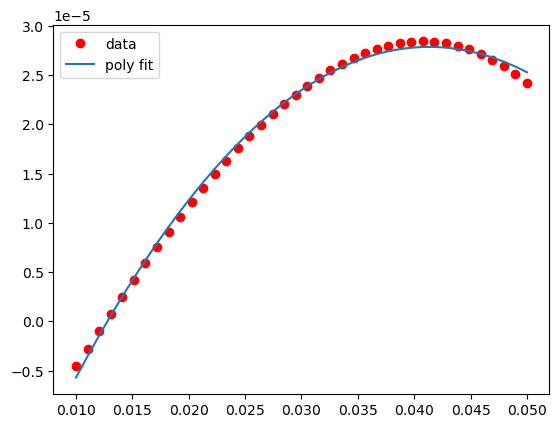

In [441]:
model2= np.poly1d(np.polyfit(true_gamma1, measured_gamma1-true_gamma1, 2))
model3=np.poly1d(np.polyfit(true_gamma1, measured_gamma1-true_gamma1, 3))
model4=np.poly1d(np.polyfit(true_gamma1, measured_gamma1-true_gamma1, 4))
model5 =np.poly1d(np.polyfit(true_gamma1[:10], measured_gamma1[:10]-true_gamma1[:10], 1))
plt.plot(true_gamma1,measured_gamma1-true_gamma1,'ro', label='data')
plt.plot(true_gamma1,model2(true_gamma1),label='poly fit')
plt.legend()
plt.show()

<font size="3">A plot showing the first 10 points between $0.01$ and $0.02$ looks decently linear.

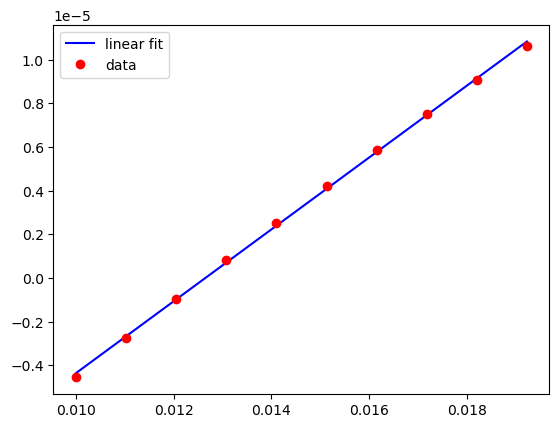

In [427]:
plt.plot(true_gamma1[:10],model5(true_gamma1[:10]),'b-',label='linear fit')
plt.plot(true_gamma1[:10],measured_gamma1[:10]-true_gamma1[:10],'ro',label='data')
plt.legend()
plt.show()

In [428]:
print(model5)
print(model5[0]) # prints the zero-th order term.

 
0.001647 x - 2.083e-05
-2.0832870171902843e-05


<font size="2">
Using the fact that the zero-th order term gives the additive bias and the first order term gives the multiplicative bias, I again did this for various value of flexion. 

Due to lack of computing resources (Galsim does not support Windows operating system and M2 chip not supported by Jax), I only produced data with 5 points for each Flexion (F1,F2,G1,G2) from 0.001 to 0.01. 

In [388]:
### prepare data
F1, F2, G1, G2 = np.linspace(0.001,0.01,5,dtype=np.float64),np.linspace(0.001,0.01,5,dtype=np.float64),np.linspace(0.001,0.01,5,dtype=np.float64),np.linspace(0.001,0.01,5,dtype=np.float64)
measured_gamma1 = np.zeros((11,5,5,5,5),dtype=np.float64)
input_gamma1 = np.linspace(0.0,0.02,11,dtype=np.float64)
gamma1_bias = np.zeros_like(measured_gamma1)
additive_bias = np.zeros((5,5,5,5),dtype=np.float64)
multiplicative_bias = np.zeros((5,5,5,5),dtype=np.float64)
for i in range(len(input_gamma1)):
    measured_gamma1[i][:][:][:][:] = fits.getdata(f'data_dep/gamma1_measured_flexion_{input_gamma1[i]:.3f}.fits')
    gamma1_bias[i][:][:][:][:] = measured_gamma1[i][:][:][:][:] - input_gamma1[i]

### use linear fit to get additive bias
for i in range(len(F1)):
    for j in range(len(F2)):
        for k in range(len(G1)):
            for l in range(len(G2)):
                model = np.poly1d(np.polyfit(input_gamma1, gamma1_bias[:,i,j,k,l], 1))
                additive_bias[i,j,k,l] = model[0]
                multiplicative_bias[i,j,k,l] = model[1]

A first look at additive bias shows ($\mathcal{O}(10^{-5}$)) that it is smaller than the multiplicative bias. Given more time I would have probably done a better job providing a fit to it. 

In [445]:
print(multiplicative_bias*100)

tensor([[[[0.1410, 0.1411, 0.1414, 0.1418, 0.1424],
          [0.1412, 0.1413, 0.1416, 0.1420, 0.1425],
          [0.1415, 0.1416, 0.1419, 0.1423, 0.1429],
          [0.1420, 0.1421, 0.1424, 0.1428, 0.1434],
          [0.1426, 0.1428, 0.1430, 0.1434, 0.1440]],

         [[0.1441, 0.1441, 0.1443, 0.1447, 0.1452],
          [0.1443, 0.1443, 0.1445, 0.1448, 0.1453],
          [0.1446, 0.1447, 0.1448, 0.1452, 0.1457],
          [0.1451, 0.1451, 0.1453, 0.1457, 0.1461],
          [0.1457, 0.1458, 0.1460, 0.1463, 0.1468]],

         [[0.1505, 0.1505, 0.1506, 0.1508, 0.1512],
          [0.1507, 0.1506, 0.1508, 0.1510, 0.1514],
          [0.1510, 0.1510, 0.1511, 0.1513, 0.1518],
          [0.1515, 0.1515, 0.1516, 0.1518, 0.1522],
          [0.1521, 0.1521, 0.1522, 0.1525, 0.1529]],

         [[0.1602, 0.1601, 0.1601, 0.1603, 0.1607],
          [0.1604, 0.1603, 0.1603, 0.1605, 0.1608],
          [0.1607, 0.1606, 0.1606, 0.1608, 0.1612],
          [0.1612, 0.1611, 0.1611, 0.1613, 0.1616],
      

Juding from the plot down below, it looks like there is a quadratic dependence on all the terms ($F_1,F_2\ldots$) for the multiplicative bias. So we need to choose for terms like $F_1^2\ldots$. From the [0,0,0,0] input, we also know there could be an offset multiplicative bias

        2
0.1508 x - 0.0001542 x + 0.00141


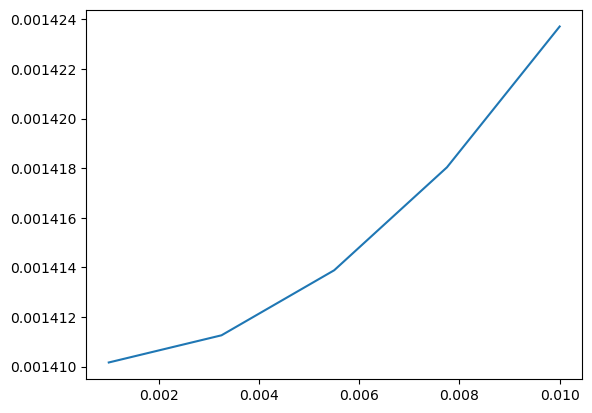

In [275]:
plt.plot(F1,multiplicative_bias[0,0,0,:])
print(np.poly1d(np.polyfit(F1, multiplicative_bias[0,0,0,:], 2)))
plt.show()

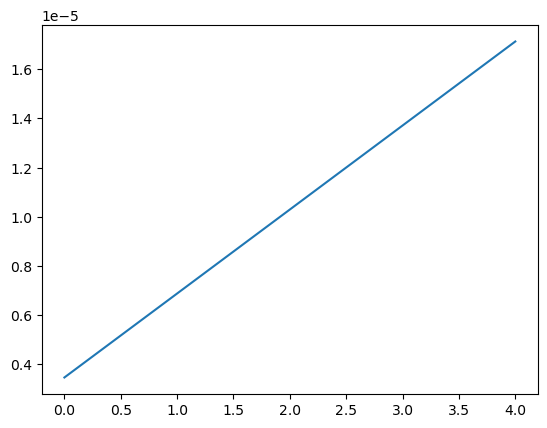

In [446]:
plt.plot(additive_bias[1,2,:,3]) # linear dependence on G, quadratic dependence on F. so could be terms with F*G
plt.show()

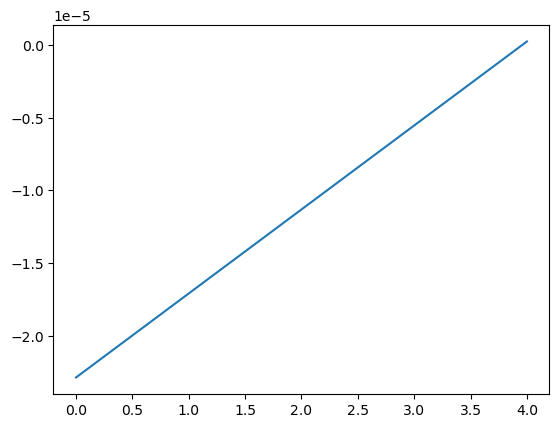

In [434]:
plt.plot(additive_bias[0,2,1,:]) # linear dependence on G, quadratic dependence on F. so could be terms with F*G
plt.show()

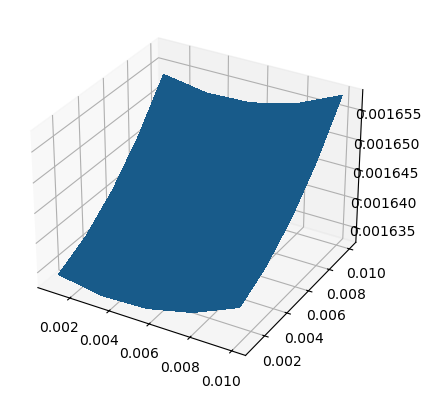

In [48]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X,Y = np.meshgrid(F1,G2)
surf = ax.plot_surface(X, Y, multiplicative_bias[1,3,:,:], linewidth=0, antialiased=False)

0.001

In [269]:
multiplicative_bias[0,0,0,0]

0.001410166221006961

In [389]:
F1, F2, G1, G2 = np.linspace(0.001,0.01,5,dtype=np.float64),np.linspace(0.001,0.01,5,dtype=np.float64),np.linspace(0.001,0.01,5,dtype=np.float64),np.linspace(0.001,0.01,5,dtype=np.float64)
F1, F2, G1, G2 = torch.from_numpy(F1),torch.from_numpy(F2),torch.from_numpy(G1),torch.from_numpy(G2)
additive_bias = torch.from_numpy(additive_bias); multiplicative_bias = torch.from_numpy(multiplicative_bias)
learning_rate = 1e-10
n_iters = 10000
#w_a = torch.FloatTensor(6, 1,require_grad=True).uniform_(0.00, 1e-6)
w_a = torch.tensor([0,0,0,0,0,0],dtype=torch.float64,requires_grad=True) # for additive bias, F1^2, F2^2, F1*F2, G1,G2, offset
w_m = torch.tensor([3.314761161804199, 3.140617132186890, 0.059470981359482, 0.165277332067490, 0.019722709432244, 0.057801250368357],requires_grad=True) # for multiplicative bias F1^2, F2^2, F1*F2, G1^2,G2^2,G1G2,offset
offset = 0.001410166221006961

In [410]:
w_m_2 = torch.tensor([3.314761161804199, 3.140617132186890, 0.059470981359482, 0.165277332067490, 0.019722709432244, 0.057801250368357,0.0013],requires_grad=True)

I defined $m$ to be consisting of terms $F^2$ and $G^2$ (cross term included) and a zeroth order offset term. 

I defined $c$ to be $F^2$ but linear in $G$ (this does not agree with spin counting, but seems to be implied by the plots earlier) and a zeroth order offset term.

In [380]:
def forward_a(F1,F2,G1,G2):
    additive_bias_est = torch.zeros_like(additive_bias)
    for i in range(5): #F1
        for j in range(5): #F2
            for k in range(5): #G1
                for l in range(5): #G2
                    additive_bias_est[i,j,k,l] = F1[i]*F1[i]*w_a[0] + F2[j]*F2[j]*w_a[1] + F1[i]*F2[j] * w_a[2] + G1[k] * w_a[3] + G2[l] * w_a[4] + w_a[5]
    return additive_bias_est

In [406]:
def forward_m(F1,F2,G1,G2):
    multiplicative_bias_est = torch.zeros_like(multiplicative_bias)
    for i in range(5): #F1
        for j in range(5): #F2
            for k in range(5): #G1
                for l in range(5): #G2
                    multiplicative_bias_est[i,j,k,l] = F1[i]*F1[i]*w_m[0] + F2[j]*F2[j]*w_m[1] + F1[i]*F2[j] * w_m[2] + G1[k] *G1[k]* w_m[3] + G2[l] *G2[l]* w_m[4] + G1[k] * G2[l] * w_m[5] + offset
    return multiplicative_bias_est

def forward_m_2(F1,F2,G1,G2):
    multiplicative_bias_est = torch.zeros_like(multiplicative_bias)
    for i in range(5): #F1
        for j in range(5): #F2
            for k in range(5): #G1
                for l in range(5): #G2
                    multiplicative_bias_est[i,j,k,l] = F1[i]*F1[i]*w_m_2[0] + F2[j]*F2[j]*w_m_2[1] + F1[i]*F2[j] * w_m_2[2] + G1[k] *G1[k]* w_m_2[3] + G2[l] *G2[l]* w_m_2[4] + G1[k] * G2[l] * w_m_2[5] + w_m_2[6]
    return multiplicative_bias_est

In [415]:
### use torch to get loss and stepper
loss_a = nn.MSELoss() 
loss_m = nn.MSELoss() 
optimizer_a = torch.optim.SGD([w_a], lr=learning_rate*1000)
optimizer_m = torch.optim.SGD([w_m], lr=1000000)
optimizer_m_2 = torch.optim.SGD([w_m_2],lr=1)

In [416]:
for epoch in range(1000):
    # predict = forward pass
    multiplicative_bias_predicted = forward_m_2(F1, F2, G1, G2)

    # loss
    l = loss_m(multiplicative_bias, multiplicative_bias_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer_m_2.step()
    # zero the gradients after updating
    optimizer_m_2.zero_grad()
    if (epoch+1) % 100 == 0:
        print(f'epoch: {epoch+1}, loss = {l.item()*1000000000000:.15f}')
        print(f'epoch: {epoch+1}, w = {w_m_2}')

epoch: 100, loss = 12.412023977294117
epoch: 100, w = tensor([3.3148e+00, 3.1406e+00, 5.9471e-02, 1.6528e-01, 1.9723e-02, 5.7801e-02,
        1.4092e-03], requires_grad=True)
epoch: 200, loss = 12.412023977294117
epoch: 200, w = tensor([3.3148e+00, 3.1406e+00, 5.9471e-02, 1.6528e-01, 1.9723e-02, 5.7801e-02,
        1.4092e-03], requires_grad=True)
epoch: 300, loss = 12.412023977294117
epoch: 300, w = tensor([3.3148e+00, 3.1406e+00, 5.9471e-02, 1.6528e-01, 1.9723e-02, 5.7801e-02,
        1.4092e-03], requires_grad=True)
epoch: 400, loss = 12.412023977294117
epoch: 400, w = tensor([3.3148e+00, 3.1406e+00, 5.9471e-02, 1.6528e-01, 1.9723e-02, 5.7801e-02,
        1.4092e-03], requires_grad=True)
epoch: 500, loss = 12.412023977294117
epoch: 500, w = tensor([3.3148e+00, 3.1406e+00, 5.9471e-02, 1.6528e-01, 1.9723e-02, 5.7801e-02,
        1.4092e-03], requires_grad=True)
epoch: 600, loss = 12.412023977294117
epoch: 600, w = tensor([3.3148e+00, 3.1406e+00, 5.9471e-02, 1.6528e-01, 1.9723e-02, 5.7

In [436]:
print(f'{w_m_2[0].item():.15f}*F1^2') #F1^2
print(f'{w_m_2[1].item():.15f}*F2^2') #F2^2
print(f'{w_m_2[2].item():.15f}*F1*F2') #F1*F2
print(f'{w_m_2[3].item():.15f}*G1^2') #G1^2
print(f'{w_m_2[4].item():.15f}*G2^2') #G2^2
print(f'{w_m_2[5].item():.15f}*G1*G2') #G1*G2
print(f'{w_m_2[6].item():.15f}(offset)')

3.314761161804199*F1^2
3.140617132186890*F2^2
0.059470981359482*F1*F2
0.165277332067490*G1^2
0.019722709432244*G2^2
0.057801250368357*G1*G2
0.001409163698554(offset)


In [398]:
# for multiplicative bias F1^2, F2^2, F1*F2, G1^2,G2^2,G1G2
# version would be without offset. offset = 0.001410166221006961
print(f'{w_m[0].item():.15f}')
print(f'{w_m[1].item():.15f}')
print(f'{w_m[2].item():.15f}')
print(f'{w_m[3].item():.15f}')
print(f'{w_m[4].item():.15f}')
print(f'{w_m[5].item():.15f}')

3.314761161804199
3.140617132186890
0.059470981359482
0.165277332067490
0.019722709432244
0.057801250368357


<font size= "3">The following plot shows that there could be some linear term here. 

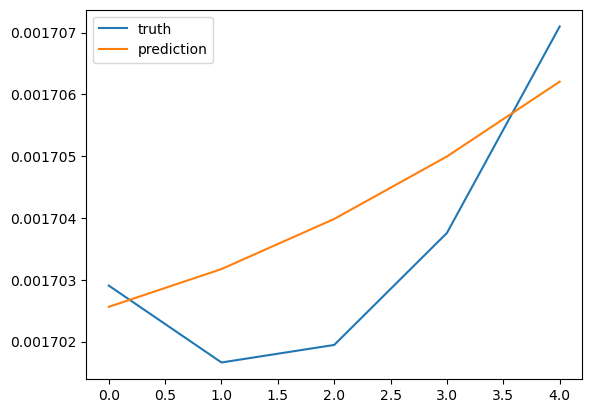

In [439]:
plt.plot(multiplicative_bias.detach().numpy()[2,3,1],label="truth")
plt.plot(multiplicative_bias_predicted.detach().numpy()[2,3,1],label="prediction")
plt.legend()
plt.show()

In [418]:
multiplicative_bias*1000

tensor([[[[1.4102, 1.4113, 1.4139, 1.4180, 1.4237],
          [1.4120, 1.4131, 1.4157, 1.4198, 1.4255],
          [1.4153, 1.4164, 1.4190, 1.4231, 1.4288],
          [1.4201, 1.4212, 1.4238, 1.4280, 1.4337],
          [1.4265, 1.4276, 1.4302, 1.4344, 1.4400]],

         [[1.4411, 1.4414, 1.4432, 1.4466, 1.4515],
          [1.4429, 1.4432, 1.4450, 1.4484, 1.4533],
          [1.4462, 1.4465, 1.4484, 1.4517, 1.4566],
          [1.4510, 1.4514, 1.4532, 1.4566, 1.4615],
          [1.4574, 1.4577, 1.4596, 1.4629, 1.4678]],

         [[1.5051, 1.5047, 1.5057, 1.5083, 1.5124],
          [1.5069, 1.5065, 1.5075, 1.5101, 1.5142],
          [1.5102, 1.5098, 1.5108, 1.5134, 1.5175],
          [1.5151, 1.5146, 1.5157, 1.5183, 1.5224],
          [1.5215, 1.5210, 1.5221, 1.5247, 1.5288]],

         [[1.6023, 1.6011, 1.6014, 1.6032, 1.6065],
          [1.6041, 1.6029, 1.6031, 1.6050, 1.6083],
          [1.6074, 1.6062, 1.6065, 1.6083, 1.6116],
          [1.6123, 1.6110, 1.6113, 1.6131, 1.6165],
      

In [417]:
multiplicative_bias_predicted*1000

tensor([[[[1.4159, 1.4162, 1.4168, 1.4175, 1.4184],
          [1.4176, 1.4182, 1.4191, 1.4201, 1.4213],
          [1.4210, 1.4219, 1.4230, 1.4243, 1.4258],
          [1.4261, 1.4273, 1.4287, 1.4303, 1.4321],
          [1.4328, 1.4343, 1.4360, 1.4379, 1.4400]],

         [[1.4461, 1.4464, 1.4469, 1.4476, 1.4486],
          [1.4478, 1.4484, 1.4492, 1.4502, 1.4514],
          [1.4512, 1.4521, 1.4532, 1.4545, 1.4560],
          [1.4562, 1.4574, 1.4588, 1.4604, 1.4622],
          [1.4630, 1.4645, 1.4662, 1.4680, 1.4701]],

         [[1.5081, 1.5084, 1.5089, 1.5096, 1.5105],
          [1.5098, 1.5104, 1.5112, 1.5122, 1.5134],
          [1.5132, 1.5141, 1.5152, 1.5165, 1.5180],
          [1.5182, 1.5194, 1.5208, 1.5224, 1.5242],
          [1.5249, 1.5264, 1.5281, 1.5300, 1.5321]],

         [[1.6018, 1.6021, 1.6027, 1.6034, 1.6043],
          [1.6035, 1.6041, 1.6050, 1.6060, 1.6072],
          [1.6069, 1.6078, 1.6089, 1.6102, 1.6117],
          [1.6120, 1.6132, 1.6146, 1.6162, 1.6180],
      

In [256]:
for epoch in range(n_iters):
    # predict = forward pass
    additive_bias_predicted = forward_a(F1, F2, G1, G2)

    # loss
    l = loss_a(additive_bias, additive_bias_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer_a.step()
    # zero the gradients after updating
    optimizer_a.zero_grad()
    if (epoch+1) % 100 == 0:
        print(f'epoch: {epoch+1}, loss = {l.item()*10000000:.15f}')
        print(f'epoch: {epoch+1}, w = {w_a}')

epoch: 100, loss = 0.034426320164774
epoch: 100, w = tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
epoch: 200, loss = 0.034426320164774
epoch: 200, w = tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
epoch: 300, loss = 0.034426320164774
epoch: 300, w = tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
epoch: 400, loss = 0.034426320164774
epoch: 400, w = tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
epoch: 500, loss = 0.034426320164774
epoch: 500, w = tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
epoch: 600, loss = 0.034426320164774
epoch: 600, w = tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
epoch: 700, loss = 0.034426320164774
epoch: 700, w = tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)


KeyboardInterrupt: 

In [258]:
multiplicative_bias

tensor([[[[0.0014, 0.0014, 0.0014, 0.0014, 0.0014],
          [0.0014, 0.0014, 0.0014, 0.0014, 0.0014],
          [0.0014, 0.0014, 0.0014, 0.0014, 0.0014],
          [0.0014, 0.0014, 0.0014, 0.0014, 0.0014],
          [0.0014, 0.0014, 0.0014, 0.0014, 0.0014]],

         [[0.0014, 0.0014, 0.0014, 0.0014, 0.0015],
          [0.0014, 0.0014, 0.0014, 0.0014, 0.0015],
          [0.0014, 0.0014, 0.0014, 0.0015, 0.0015],
          [0.0015, 0.0015, 0.0015, 0.0015, 0.0015],
          [0.0015, 0.0015, 0.0015, 0.0015, 0.0015]],

         [[0.0015, 0.0015, 0.0015, 0.0015, 0.0015],
          [0.0015, 0.0015, 0.0015, 0.0015, 0.0015],
          [0.0015, 0.0015, 0.0015, 0.0015, 0.0015],
          [0.0015, 0.0015, 0.0015, 0.0015, 0.0015],
          [0.0015, 0.0015, 0.0015, 0.0015, 0.0015]],

         [[0.0016, 0.0016, 0.0016, 0.0016, 0.0016],
          [0.0016, 0.0016, 0.0016, 0.0016, 0.0016],
          [0.0016, 0.0016, 0.0016, 0.0016, 0.0016],
          [0.0016, 0.0016, 0.0016, 0.0016, 0.0016],
      

In [84]:
predicted = forward_a(F1, F2, G1, G2).detach().numpy()
additive_bias = additive_bias.detach().numpy()